In [2]:
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter
import shutil
import os
import csv
import requests
from bs4 import BeautifulSoup
from io import StringIO
import random
import re
import nbimporter
from Bio.SeqRecord import SeqRecord
import torch
from pycaret.classification import *
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

### Data
##### The matrix id and the uniport id are all get from the JASPAR website satisfying Homo sapiens, collection is “CORE” and tax_group is “vertebrates”, also recorded the name, class, Family and data type (success_download.csv). There are 330 DNA FASTA files and 681 protein FASTA files.
##### The DNA sequence and protein sequence are also being downloaded and stored in the folder.


In [2]:
DNA_inf = pd.read_csv("success_download.csv")
matrix_ID_list = []

for i in range(len(DNA_inf)):
    matrix_ID_list.append(DNA_inf.loc[i,"ID"])

In [3]:
print(f"DNA FASTA files: {len(matrix_ID_list)}")

DNA FASTA files: 330


### Data Exploration
##### The DNA are assigned into three different groups based on the data type: 
###### SELEX, High-throughput SELEX SAGE, HT-SELEX
###### ChIP-seq, ChIP-chip
###### COMPILED, bacterial 1-hybrid, NA

In [6]:
# import function from other .ipynb file
from Sep_01_plot import Get_lent
df = pd.read_csv("success_download.csv")

There are 43 total rows of data


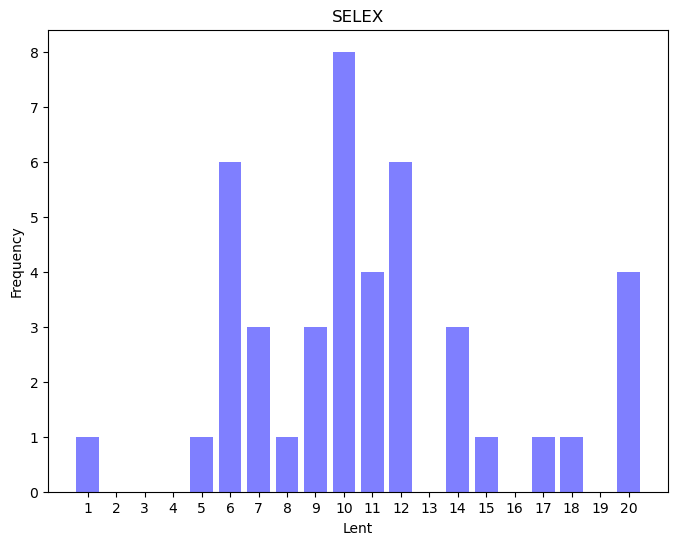

In [12]:
# SELEX, High-throughput SELEX SAGE, HT-SELEX
selex_result = []
selex_plot_data = []

SELEX_rows = df[df['Data type'] == 'SELEX']
for id in SELEX_rows['ID']:
    result = Get_lent(id)
    selex_result.append(result)
    selex_plot_data.append(result[1])

SELEX_SAGE_rows = df[df['Data type'] == 'High-throughput SELEX SAGE']
for id in SELEX_SAGE_rows['ID']:
    result = Get_lent(id)
    selex_result.append(result)
    selex_plot_data.append(result[1])
    
HT_SELEX_rows = df[df['Data type'] == 'HT-SELEX']
for id in HT_SELEX_rows['ID']:
    result = Get_lent(id)
    selex_result.append(result)
    selex_plot_data.append(math.ceil(result[1]))
    
# check the correct or not
if len(SELEX_rows)+len(SELEX_SAGE_rows)+len(HT_SELEX_rows) != len(selex_result):
    print("ERROR!!!!!!!!!!!!!!!!")
else:
    print(f"There are {len(selex_result)} total rows of data")

plt.figure(figsize=(8, 6))
selex_value_counts = pd.Series(selex_plot_data).value_counts().sort_index()
plt.bar(selex_value_counts.index, selex_value_counts.values, color='blue',alpha = 0.5)
plt.xticks(np.arange(math.floor(min(selex_value_counts.index)), math.ceil(max(selex_value_counts.index))+1, 1))
plt.xlabel('Lent')
plt.ylabel('Frequency')
plt.title('SELEX')
plt.show()

There are 250 total rows of data


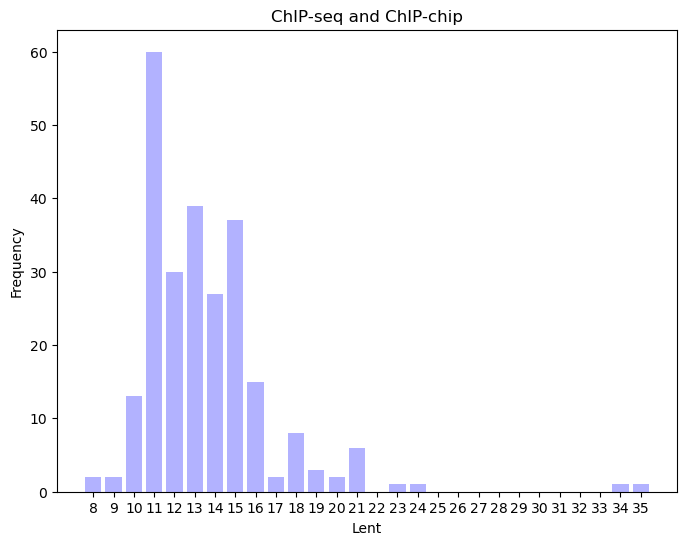

In [16]:
# ChIP-seq, ChIP-chip
ChIP_result = []
ChIP_plot_data = []

ChIP_seq_rows = df[df['Data type'] == 'ChIP-seq']
for id in ChIP_seq_rows['ID']:
    result = Get_lent(id)
    ChIP_result.append(result)
    ChIP_plot_data.append(result[1])

ChIP_chip_rows = df[df['Data type'] == 'ChIP-chip']
for id in ChIP_chip_rows['ID']:
    result = Get_lent(id)
    ChIP_result.append(result)
    ChIP_plot_data.append(result[1])

    
# check the correct or not
if len(ChIP_seq_rows)+len(ChIP_chip_rows) != len(ChIP_result):
    print("ERROR!!!!!!!!!!!!!!!!")
else:
    print(f"There are {len(ChIP_result)} total rows of data")

plt.figure(figsize=(8, 6))
CHIP_value_counts = pd.Series(ChIP_plot_data).value_counts().sort_index()
plt.bar(CHIP_value_counts.index, CHIP_value_counts.values, color='blue',alpha = 0.3)
plt.xticks(np.arange(math.floor(min(CHIP_value_counts.index)), math.ceil(max(CHIP_value_counts.index))+1, 1))
plt.xlabel('Lent')
plt.ylabel('Frequency')
plt.title('ChIP-seq and ChIP-chip')
plt.show()

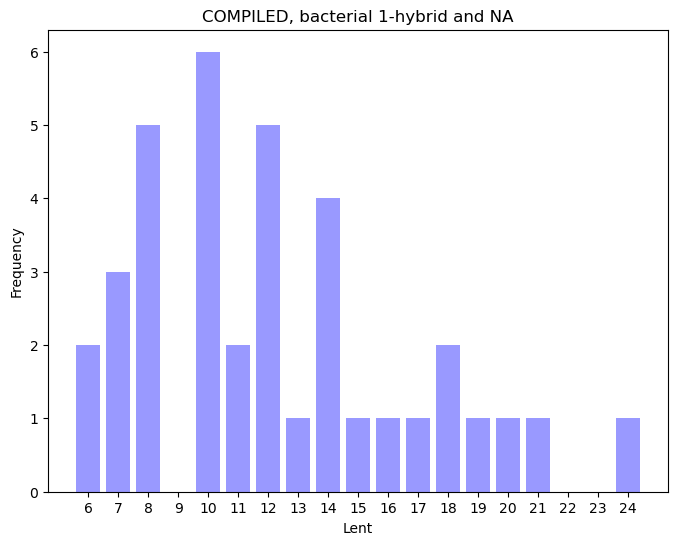

In [17]:
#COMPILED, bacterial 1-hybrid, NA
other_result = []
other_plot_data = []

# COMPILED
COMPILED_rows = df[df['Data type'] == 'COMPILED']
for id in COMPILED_rows['ID']:
    result = Get_lent(id)
    other_result.append(result)
    other_plot_data.append(result[1])
    
# bacterial 1-hybrid
bacterial_1_hybrid_rows = df[df['Data type'] == 'bacterial 1-hybrid']
for id in bacterial_1_hybrid_rows['ID']:
    result = Get_lent(id)
    other_result.append(result)
    other_plot_data.append(result[1])
    
NA_rows = df[df['Data type'].isnull()]
for id in NA_rows['ID']:
    result = Get_lent(id)
    other_result.append(result)
    other_plot_data.append(result[1])

# check the correct or not
if len(COMPILED_rows)+len(bacterial_1_hybrid_rows)+len(NA_rows) != len(other_result):
    print("ERROR!!!!!!!!!!!!!!!!")

plt.figure(figsize=(8, 6))
other_value_counts = pd.Series(other_plot_data).value_counts().sort_index()
plt.bar(other_value_counts.index, other_value_counts.values, color='blue',alpha = 0.4)
plt.xticks(np.arange(math.floor(min(other_value_counts.index)), math.ceil(max(other_value_counts.index))+1, 1))
plt.xlabel('Lent')
plt.ylabel('Frequency')
plt.title('COMPILED, bacterial 1-hybrid and NA')
plt.show()

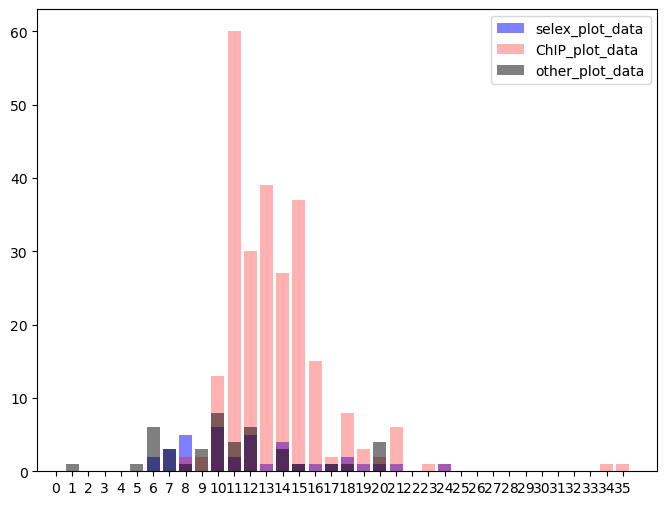

In [18]:
plt.figure(figsize=(8, 6))
plt.bar(other_value_counts.index, other_value_counts.values, color='blue',alpha = 0.5)
plt.bar(CHIP_value_counts.index, CHIP_value_counts.values, color='red',alpha = 0.3)
plt.bar(selex_value_counts.index, selex_value_counts.values, color='black',alpha = 0.5)
plt.legend(["selex_plot_data","ChIP_plot_data","other_plot_data"])
plt.xticks(np.arange(0, 36, 1))
plt.show()

### Generating negative data:
##### Before that, I only keep the uppercase of the sequence and remove the lowercase for every DNA sequences.
##### To generate the negative data, I random shuffle all the DNA sequence.


In [21]:
from Sep_07_random import uppercase_pos, shuffle_sequence
DNA_inf = pd.read_csv("success_download.csv")
matrix_ID_list = []

for i in range(len(DNA_inf)):
    matrix_ID_list.append(DNA_inf.loc[i,"ID"])
matrix_ID_list.remove("MA0036.1")

In [ ]:
for matrix_name in matrix_ID_list:
    folder = "FASTA_80hom/"
    fasta_matrix = f"{folder}{matrix_name}_80hom.fasta"
    with open(fasta_matrix, "r") as file:
        sequences = list(SeqIO.parse(file, "fasta"))
        
    unique_shuffled_sequences = set()
    for sub_sequence in sequences:
        
        if "(" not in sub_sequence.id and ")" not in sub_sequence.id:
            sub_sequence.description = re.sub(r'\([^)]*\)', '', sub_sequence.description)
        else:
            new_string = re.sub(r'\([^)]*\)', '', sub_sequence.description)
            sub_sequence.id = new_string
            sub_sequence.description = new_string
            sub_sequence.name = new_string
            
        check = False
        
        upper_pos = uppercase_pos(sub_sequence.seq)
        if upper_pos == []:
            continue
        else:
            start = sub_sequence.seq[0 : 0]
            seq_list = list(sub_sequence.seq[upper_pos[0]:upper_pos[-1]+1])
            random.shuffle(seq_list)
            lent =  ''.join(seq_list)

            unique_shuffled_sequences.add(lent)
            
            sub_sequence.seq = start + lent
# Following part will store each random shuffled file into a folder.    
    '''
    with open(f"{matrix_name}_80hom_random.fasta", "w") as fileabc:
        SeqIO.write(sequences, fileabc, "fasta")   
    destination_path = f"FASTA_80hom_random/{matrix_name}_80hom_random.fasta"
    if os.path.exists(destination_path):
        os.remove(destination_path)
    shutil.move(f"{matrix_name}_80hom_random.fasta", "FASTA_80hom_random")
    '''    

##### To keep the similarity with the positive data (the initial data) low, I do in two ways:

##### 1.	Based on the similarity: I make an iteration that will check the similarity of each negative sequence with all the positive sequence according to the longest common subsequence. If there is one negative sequence that has over 0.7 similarity with the positive, this negative sequence will be reshuffle and check from the begin. This method takes too much time since the complexity is too high for the iteration (n3), so the negative data generated in this way is not being used (but it has been generated ^_^).

In [ ]:
# This part code will take a lot of time to finish, so better not run on the jupyter
from Sep_07_random import longest_common_subsequence
for matrix_name in matrix_ID_list:
    folder_pos = "FASTA_80hom/"
    fasta_matrix_pos = f"{folder_pos}{matrix_name}_80hom.fasta"
    with open(fasta_matrix_pos, "r") as file_pos:
        sequences_pos = list(SeqIO.parse(file_pos, "fasta"))
        
    folder_nag = "FASTA_80hom_random/"
    fasta_matrix_nag = f"{folder_nag}{matrix_name}_80hom_random.fasta"
    with open(fasta_matrix_nag, "r") as file_nag:
        sequences_nag = list(SeqIO.parse(file_nag, "fasta"))
    
    i = 0
    for sub_sequence1 in sequences_nag:
        j = 0
        if i % 50 == 0:
            print(f"-------------negative data {i} line-------------")
        sub_sequence_nag = sub_sequence1.seq
        
        for sub_sequence2 in sequences_pos:
            reroll = False
            sub_sequence_pos = ''.join([char for char in sub_sequence2.seq if char.isupper()])
            similarity = longest_common_subsequence(sub_sequence_nag,sub_sequence_pos)
            
            if similarity >= 0.8:
                print(similarity)
                reroll = True
                
            while reroll == True:
                start = sub_sequence1.seq[0:0]
                lent = shuffle_sequence(sub_sequence1.seq)
                sub_sequence1.seq = start + lent
                similarity_list = []
                for sub_sequence2_check in sequences_pos[0:j+1]:
                    sub_sequence_pos_check = ''.join([char for char in sub_sequence2_check.seq if char.isupper()])
                    similarity = longest_common_subsequence(sub_sequence1.seq,sub_sequence_pos_check)
                    similarity_list.append(similarity)
                if max(similarity_list) < 0.8:
                    reroll = False 
            j += 1
        i += 1
# Following part will store the file after processing into a folder.
    ''''
    with open(f"{matrix_name}_random.fasta", "w") as fileabc:
        SeqIO.write(sequences_nag, fileabc, "fasta")   
    destination_path = f"FASTA_80hom_negative_simi/{matrix_name}_random.fasta"
    if os.path.exists(destination_path):
        os.remove(destination_path)
    shutil.move(f"{matrix_name}_random.fasta", "FASTA_80hom_negative_simi")
    ''''    

##### 2.	Based on the frequency matrix: the new negative sequence is generated based on the Frequency matrix of each DNA get from JASPAR. The lower score will have the high probability to be assigned to each position. The negative data generated in this way is used in later processing.

In [25]:
from Sep_15_generate_neg_matrix import check_score
DNA_inf = pd.read_csv("success_download.csv")
matrix_ID_list = []
for i in range(len(DNA_inf)):
    matrix_ID_list.append(DNA_inf.loc[i,"ID"])

In [ ]:
# This part code may also take much time to finish, so better not run on the jupyter
for matrix_name in matrix_ID_list:
    fasta_matrix = f"FASTA_80hom/{matrix_name}_80hom.fasta"
    with open(fasta_matrix, "r") as file:
        sequences = list(SeqIO.parse(file, "fasta"))

    jaspar_matrix = f"Frequency_matrix/download_JASPAR/{matrix_name}.jaspar"
    with open(jaspar_matrix) as f:
        jaspar_motifs = motifs.parse(f, "jaspar")

    for motif in jaspar_motifs:
        motif.__dict__['counts']
    
    ls = []   
    for n in range(len(sequences)):
        checkpass = False    
        while checkpass == False:
            sequences_new = ''
            letters = ['A', 'C', 'G', 'T']
            length = len(motif)
            for i in range(length):
                weights = {'A': motif.__dict__['counts']['A'][i]+1, 'C': motif.__dict__['counts']['C'][i]+1,
                           'G': motif.__dict__['counts']['G'][i]+1, 'T': motif.__dict__['counts']['T'][i]+1}
                letters = list(weights.keys())

                total_inverse = 0
                for weight in weights.values():
                    total_inverse += 1/weight
        
                probabilities = []
                for letter in letters:
                    probabilities.append((1/weights[letter]) / total_inverse)
                new_seq = ''.join(random.choices(letters, weights=probabilities, k=1))
                sequences_new += new_seq
        
            score, max_score = check_score(sequences_new)
            if sequences_new not in ls and score <= (max_score/4):
                ls.append(sequences_new)
                checkpass = True
    
        sequences[n].seq = sequences[n].seq[0 : 0] + sequences_new
        if "(" not in sequences[n].id and ")" not in sequences[n].id:
            sequences[n].description = re.sub(r'\([^)]*\)', '', sequences[n].description)
        else:
            new_string = re.sub(r'\([^)]*\)', '', sequences[n].description)
            sequences[n].id = new_string
            sequences[n].description = new_string
            sequences[n].name = new_string
# Following part will store the file after processing into a folder.
'''
    with open(f"{matrix_name}_matrix_similarity.fasta", "w") as fileabc:
        SeqIO.write(sequences, fileabc, "fasta")   
    destination_path = f"FASTA_80hom_negative_m/{matrix_name}_matrix_similarity.fasta"
    if os.path.exists(destination_path):
        os.remove(destination_path)
    shutil.move(f"{matrix_name}_matrix_similarity.fasta", "FASTA_80hom_negative_m")
'''   

### Data pre-processing:
##### Before the training, I make all the DNA sequence length to the same, which is 11. If the length is higher than 11, the addition sequence will be removed. And if the length is smaller than 11, the closest lowercase sequence will be changed into uppercase.



In [2]:
from Sep_20_cleaning import count_uppercase_chars,check_unequal,copy_file,modify,uppercase_pos
DNA_inf = pd.read_csv("success_download.csv")
matrix_ID_list = []

for i in range(len(DNA_inf)):
    matrix_ID_list.append(DNA_inf.loc[i,"ID"])
matrix_ID_list.remove("MA0036.1")

In [ ]:
need_modify = []
for matrix_name in matrix_ID_list:
    need_modify.append(modify(matrix_name))

In [ ]:
for matrix_name in need_modify:
    folder = "FASTA_matrix_initial/"
    fasta_matrix = f"{folder}{matrix_name}.fasta"
    
    with open(fasta_matrix, "r") as file:
        sequences = list(SeqIO.parse(file, "fasta"))
    
    upper_sequence = []
    for seq_record in sequences:
        upper_sequence.append(count_uppercase_chars(seq_record.seq))

    element_counts = Counter(upper_sequence)
    most_common_element = max(element_counts.most_common(), key=lambda x: x[0])[0]

    error_sequence = check_unequal(upper_sequence,most_common_element)
    

    for seq in error_sequence:
        if len(sequences[seq]) == most_common_element:
            sequences[seq].seq = sequences[seq].seq.upper()
        else:
            print(matrix_name + " need modified")
            break
# Following part will store result file into a folder.  
'''
    file_path = f"{matrix_name}_cleaning.fasta"
    with open(file_path, "w") as fileabc:
        SeqIO.write(sequences, fileabc, "fasta")   
    shutil.move(file_path, "clean1_9.20/")
'''

##### In order to make the later process be convenient, I generated a csv file including positive sequence, negative sequence, matrix id, uniport id and the score. The “Label” is used to verifying positive data (1) and negative data (0). The total number of rows are 283204 rows.

In [4]:
qwerty = pd.read_csv("matrix_pos_neg_seq_80hom.csv")
qwerty

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label
0,MA0002.1,Q01196,AATTGTGGTTA,0.995146,1
1,MA0002.1,Q01196,ATCTGTGGTTA,0.956311,1
2,MA0002.1,Q01196,TTCTGCGGTTA,0.922330,1
3,MA0002.1,Q01196,AATTGCGGTAA,0.917476,1
4,MA0002.1,Q01196,TATTGCGGTTT,0.932039,1
...,...,...,...,...,...
283199,MA1986.1,Q9BU19,GAACTTACAT,0.099733,0
283200,MA1986.1,Q9BU19,CAACAAACAT,0.077105,0
283201,MA1986.1,Q9BU19,ATTCGTTTAT,0.066380,0
283202,MA1986.1,Q9BU19,TTACATATAA,0.087408,0


##### The Sequence only remain the one with similarity between one and others are lower by the 80%.

### Feature:
##### The feature used to do the classification are one_hot_encoding_DNA, Word2Vec_encoding_DNA and protein_embedding_sequence. In order to shorten the time of training, I pre-running the encoding for all the DNA and protein sequence, and every the encoding results are stored as json files.
##### Word2Vec setting: Word2Vec([k_mers], vector_size=11, window=5, min_count=1, workers=4)


In [ ]:
# store the result of one hot coding DNA as json dictionary
df = pd.read_csv("10.9_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)
alphabet = 'ATCGX'
one_hot_DNA = {}
for n in range(len(df)):
    input_string = df['DNA_Sequence'][n]
    char_to_index = {char: i for i, char in enumerate(alphabet)}
    one_hot_matrix = np.zeros((len(input_string), len(alphabet)),dtype=int)

    for i, char in enumerate(input_string):
        if char in char_to_index:
            one_hot_matrix[i, char_to_index[char]] = 1
    one_hot_matrix = one_hot_matrix.astype(str)
    
    chac_list = []
    for i in range(len(one_hot_matrix)):
        chac = ''
        for j in range(len(one_hot_matrix[i])):
            chac += one_hot_matrix[i][j]
        chac_list.append(chac)
    result = ''
    for a in range(len(chac_list)):
        result += chac_list[a]
    one_hot_DNA[input_string] = result
# Following part will store the one hot coding DNA into a json file.  
'''
with open('one_hot_encoding_DNA.json', 'w') as file:
    json.dump(one_hot_DNA, file)
'''

In [ ]:
# store the result of Word2Vec DNA as json dictionary
from gensim.models import Word2Vec
result = {}
for i in range(len(df)):
    temp_gen = []
    sequences = [df['DNA_Sequence'][i]]
    k_mer_size = 3
    k_mers = [''.join(seq[i:i+k_mer_size]) for seq in sequences for i in range(len(seq) - k_mer_size + 1)]

    model = Word2Vec([k_mers], vector_size=11, window=5, min_count=1, workers=4)
    for k_mer in k_mers:
        temp_gen +=  model.wv[k_mer].tolist()  
    result[sequences[0]] = temp_gen
# Following part will store the Word2Vec DNA into a json file.  
'''
with open('Word2Vec_encoding_DNA.json', 'w') as file:
    json.dump(result, file)
'''   

In [ ]:
# store the result of protein embedding as json dictionary
embeddings_0 = {}
embeddings_33 = {}

for file in file_name:
    a = torch.load('human_650m/' + file)
    embeddings_0[a['label'].split('|')[1]] = (a['mean_representations'][0].tolist())
    embeddings_33[a['label'].split('|')[1]] = (a['mean_representations'][0].tolist())
# Following part will store the protein embedding into a json file. 
'''
with open('protein_sequence.json', 'w') as file:
    json.dump(protein_dict, file)
'''

### Classification:

##### For the first try, I only selected 10000 rows randomly to see the result. The csv file of the features has 1434 columns (1280 protein embedding + 99 DNA Word2Vec encoding + 55 DNA one hot coding) + 1 label. 

In [6]:
df = pd.read_csv("10.6_used_in_classfication_80hom.csv")
protein_ID_list = []

for i in range(len(df)):
    protein_ID_list.append(df.loc[i,"Uniprot_ID"])
df = df[df['Uniprot_ID'] != "P48743"]
df.reset_index(drop=True, inplace=True)   
df

,Matrix_ID,Uniprot_ID,DNA_Sequence,score/max_score,Label,protein_sequence
0,MA0829.2,P36956,TGAGATGTCAG,0.125798,0,MDEPPFSEAALEQALGEPCDLDAALLTDIEDMLQLINNQDSDFPGL...
1,MA0102.4,P49715,CGCCGGGGCAG,0.137740,0,MESADFYEAEPRPPMSSHLQSPPHAPSSAAFGFPRGAGPAQPPAPP...
2,MA0495.2,Q9ULX9,GCTTGGTCAGC,0.829235,1,MSVDPLSSKALKIKRELSENTPHLSDEALMGLSVRELNRHLRGLSA...
3,MA0052.4,Q02078,TGGCCCCACCA,0.191967,0,MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...
4,MA0782.2,P55347,CGAGTGTCAGC,0.826563,1,MMATQTLSIDSYQDGQQMQVVTELKTEQDPNCSEPDAEGVSPPPVE...
...,...,...,...,...,...,...
9908,MA0852.2,P85037,TGTACACAGGC,0.851684,1,MAEVGEDSGARALLALRSAPCSPVLCAAAAAAAFPAAAPPPAPAQP...
9909,MA0761.2,P50549,GGTTATCAGTT,0.164993,0,MDGFYDQQVPYMVTNSQRGRNCNEKPTNVRKRKFINRDLAHDSEEL...
9910,MA1929.1,P49711,TCCGCCGGCAA,0.229611,0,MEGDAVEAIVEESETFIKGKERKTYQRRREGGQEEDACHLPQNQTD...
9911,MA0495.3,Q9ULX9,AGCCACCGCGA,0.136651,0,MSVDPLSSKALKIKRELSENTPHLSDEALMGLSVRELNRHLRGLSA...


In [7]:
# the data of 10000 sample I have store in the csv file
try1 = pd.read_csv("10.9_factor.csv")
try1['Label'] = df['Label']

In [ ]:
# This part may take too much memory, so I only show part of it
from pycaret.classification import *
s = ClassificationExperiment()
s.setup(try1, target = 'Label', session_id = 123)
best = s.compare_models()

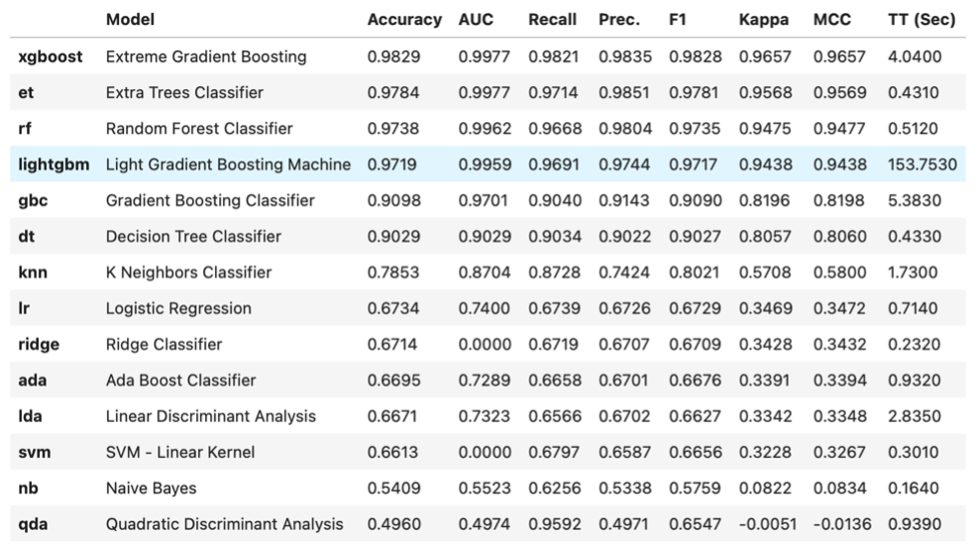

In [14]:
Image(filename="report_figure/figure1.png",width=600,height=600)

##### 80 training:20 testing (224634 : 56158) random and pos:neg = 1:1 (training positive = training negative = 112317; testing negative = testing positive = 28079).
##### This part is running on the NSCC, as odin and jupyter cannot run such large data.

In [ ]:
df = pd.read_csv("10.9_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)

training1_pos = df[df['Label'] == 1].sample(frac=0.8, random_state=1)
testing1_pos = df[df['Label'] == 1].drop(training1_pos.index)

training1_neg = df[df['Label'] == 0].sample(frac=0.8, random_state=1)
testing1_neg = df[df['Label'] == 0].drop(training1_neg.index)

training1 = pd.concat([training1_pos, training1_neg], ignore_index=True)
testing1 = pd.concat([testing1_pos, testing1_neg], ignore_index=True)

with open('protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)
    
peseq = protein_embedding_sequence[training1['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[training1['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[training1['DNA_Sequence'][0]]

training = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

training1_feature = pd.DataFrame.from_dict(training, orient='index')
for i in range(len(training1)):
    print(i)
    peseq = protein_embedding_sequence[training1['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[training1['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[training1['DNA_Sequence'][i]]
    name = str(i)
    training1_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]
training1_feature['Label'] = training1['Label'].tolist()
#training1_feature.to_csv('Classification_1/training.csv', index=False)

peseq = protein_embedding_sequence[testing1['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[testing1['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[testing1['DNA_Sequence'][0]]

testing = {
    '0': peseq + [int(char) for char in ohe_dna] + word2vec_dna
}

testing1_feature = pd.DataFrame.from_dict(testing, orient='index')
for i in range(len(testing1)):
    print(i)
    peseq = protein_embedding_sequence[testing1['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[testing1['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[testing1['DNA_Sequence'][i]]
    name = str(i)
    testing1_feature.loc[name] = peseq + [int(char) for char in ohe_dna] + word2vec_dna
testing1_feature['Label'] = testing1['Label'].tolist()
#testing1_feature.to_csv('Classification_1/testing.csv', index=False)

In [ ]:
# Do not run on jupyter for this part!!!!!!!!!!
from pycaret.classification import *

print("begins")
training1 = pd.read_csv("/home/users/ntu/leiz0003/data1/training.csv", index_col=None)
testing1 = pd.read_csv("/home/users/ntu/leiz0003/data1/testing.csv", index_col=None)
testing1.index = pd.RangeIndex(start=224634, stop=280792)

print("finish reading")

s = setup(data=training1,
      target='Label',
      test_data=testing1)

print("start modeling")

data1 = s.compare_models(include = ['rf','svm','nb','et','dt'])
results = s.pull()

rf_accuracy = results.loc['rf', 'Accuracy']
svm_accuracy = results.loc['svm', 'Accuracy']
nb_accuracy = results.loc['nb', 'Accuracy']
et_accuracy = results.loc['et', 'Accuracy']
dt_accuracy = results.loc['dt', 'Accuracy']

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"svm: {svm_accuracy}")
print(f"nb_accuracy: {nb_accuracy}")
print(f"et_accuracy: {et_accuracy}")
print(f"dt_accuracy: {dt_accuracy}")

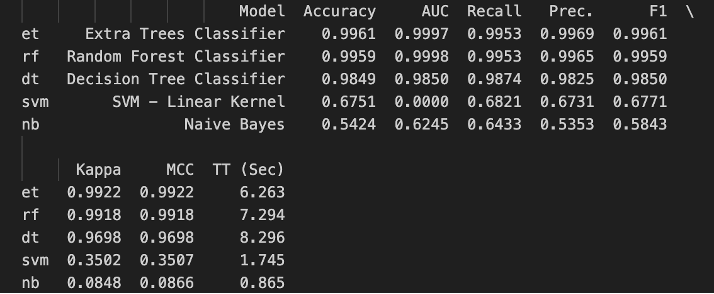

In [15]:
Image(filename="report_figure/figure2.png",width=600,height=600)

##### The sequence of each protein are divided into 80% training and 20% testing, and also keep pos:neg = 1:1.
##### This part is running on the NSCC, as odin and jupyter cannot run such large data.

In [ ]:
df = pd.read_csv("10.9_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)

protein_ls = list(set(df['Uniprot_ID']))

training2 = pd.DataFrame(columns=['Matrix_ID',
                                  'Uniprot_ID',
                                  'DNA_Sequence',
                                  'score/max_score',
                                  'Label',
                                  'protein_sequence'])
testing2 = pd.DataFrame(columns=['Matrix_ID',
                                  'Uniprot_ID',
                                  'DNA_Sequence',
                                  'score/max_score',
                                  'Label',
                                  'protein_sequence'])
for protein in protein_ls:
    temp = df[df['Uniprot_ID'] == protein]
    training2_pos_temp = temp[temp['Label'] == 1].sample(frac=0.8, random_state=1)
    testing2_pos_temp = temp[temp['Label'] == 1].drop(training2_pos_temp.index)
    
    training2_neg_temp = temp[temp['Label'] == 0].sample(frac=0.8, random_state=1)
    testing2_neg_temp = temp[temp['Label'] == 0].drop(training2_neg_temp.index)
    
    training2_temp = pd.concat([training2_pos_temp, training2_neg_temp], ignore_index=True)
    testing2_temp = pd.concat([testing2_pos_temp, testing2_neg_temp], ignore_index=True)
    
    training2 = pd.concat([training2, training2_temp], ignore_index=True)
    testing2 = pd.concat([testing2, testing2_temp], ignore_index=True)

with open('protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)

peseq2 = protein_embedding_sequence[training2['Uniprot_ID'][0]]
ohe_dna2 = one_hot_encoding_DNA[training2['DNA_Sequence'][0]]
word2vec_dna2 = Word2Vec_encoding_DNA[training2['DNA_Sequence'][0]]

training = {
    '0': peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
}

training2_feature = pd.DataFrame.from_dict(training, orient='index')
for i in range(len(training2)):
    print(i)
    peseq2 = protein_embedding_sequence[training2['Uniprot_ID'][i]]
    ohe_dna2 = one_hot_encoding_DNA[training2['DNA_Sequence'][i]]
    word2vec_dna2 = Word2Vec_encoding_DNA[training2['DNA_Sequence'][i]]
    name = str(i)
    training2_feature.loc[name] = peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
    
training2_feature['Label'] = training2['Label'].tolist()
#training2_feature.to_csv('Classification_2/training.csv', index=False)

peseq2 = protein_embedding_sequence[testing2['Uniprot_ID'][0]]
ohe_dna2 = one_hot_encoding_DNA[testing2['DNA_Sequence'][0]]
word2vec_dna2 = Word2Vec_encoding_DNA[testing2['DNA_Sequence'][0]]

testing = {
    '0': peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
}

testing2_feature = pd.DataFrame.from_dict(testing, orient='index')
for i in range(len(testing2)):
    print(i)
    peseq2 = protein_embedding_sequence[testing2['Uniprot_ID'][i]]
    ohe_dna2 = one_hot_encoding_DNA[testing2['DNA_Sequence'][i]]
    word2vec_dna2 = Word2Vec_encoding_DNA[testing2['DNA_Sequence'][i]]
    name = str(i)
    testing2_feature.loc[name] = peseq2 + word2vec_dna2 + [int(char2) for char2 in ohe_dna2]
    
testing2_feature['Label'] = testing2['Label'].tolist()
#testing2_feature.to_csv('Classification_2/testing.csv', index=False)

In [ ]:
# Do not run on jupyter for this part!!!!!!!!!!
import pandas as pd
import numpy as np
from pycaret.classification import *

print("2begins")
training2 = pd.read_csv("/home/users/ntu/leiz0003/data2/training2.csv", index_col=None)
testing2 = pd.read_csv("/home/users/ntu/leiz0003/data2/testing2.csv", index_col=None)
testing2.index = pd.RangeIndex(start=224630, stop=280792)

print("2finish reading")

s = setup(data=training2,
      target='Label',
      test_data=testing2,
      log_experiment = True)

print("3start modeling")
data2 = s.compare_models(include = ['rf','svm','nb','et','dt'])

results = s.pull()
rf_accuracy = results.loc['rf', 'Accuracy']
svm_accuracy = results.loc['svm', 'Accuracy']
nb_accuracy = results.loc['nb', 'Accuracy']
et_accuracy = results.loc['et', 'Accuracy']
dt_accuracy = results.loc['dt', 'Accuracy']

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"svm: {svm_accuracy}")
print(f"nb_accuracy: {nb_accuracy}")
print(f"et_accuracy: {et_accuracy}")
print(f"dt_accuracy: {dt_accuracy}")

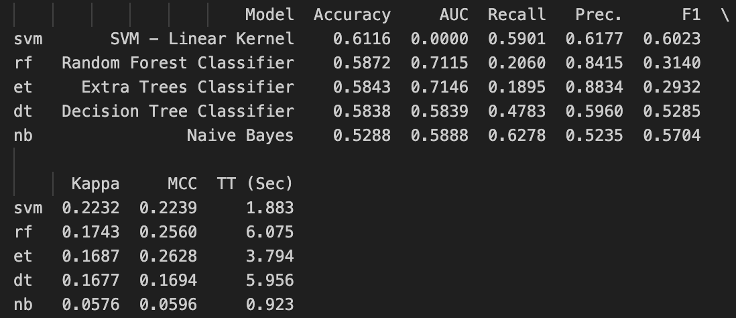

In [16]:
Image(filename="report_figure/figure3.png",width=600,height=600)

##### There is no common protein in training set and testing set, and the protein structure of the training set and testing are similar.
##### This part is running on the NSCC, as odin and jupyter cannot run such large data.

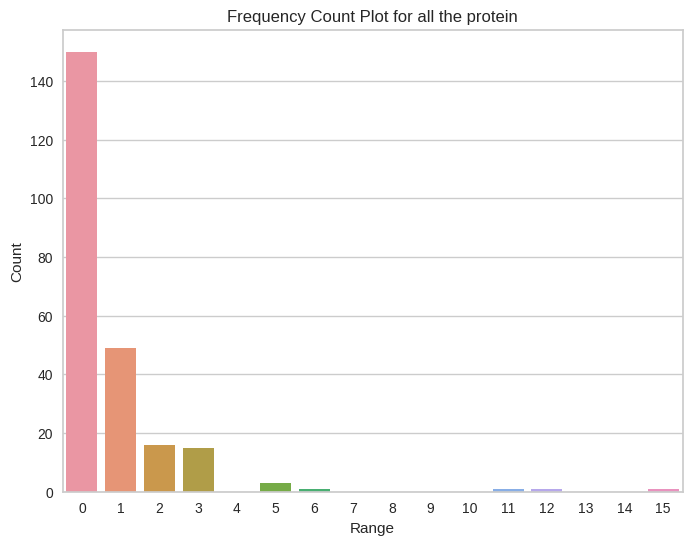

In [21]:
df = pd.read_csv("10.9_DNA_protein.csv")
df = df[df['Uniprot_ID'] != "P48743"]
df = df[df['Uniprot_ID'] != "Q53XW4"]
df.reset_index(drop=True, inplace=True)

protein_count = df['Uniprot_ID'].value_counts().reset_index()
protein_count.columns = ['Uniprot_ID', 'Count']

bins = list(range(0, 16001, 1000))
Labels = list(range(0, 16))

protein_count['range'] = pd.cut(protein_count['Count'], bins=bins,
                                labels=Labels,
                                right=False)

bin_counts = protein_count['range'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values)
plt.title('Frequency Count Plot for all the protein')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

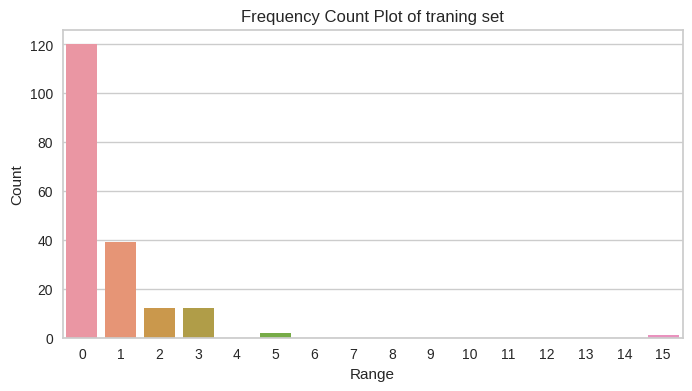

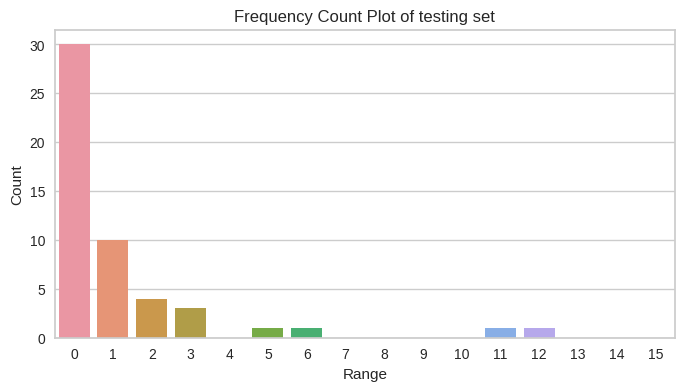

In [27]:
training3_protein = ['P49711']
testing3_protein = ['O75030','Q9ULX9']
range_ls = list(set(protein_count['range']))
range_ls.remove(11)
range_ls.remove(12)
range_ls.remove(15)
random.seed(1)
for count_range in range_ls:
    temp_range_df = protein_count[protein_count['range'] == count_range]
    temp_protein_id = temp_range_df['Uniprot_ID'].tolist()
    random.shuffle(temp_protein_id)
    split_index = int(0.8 * len(temp_protein_id))

    training3_protein += temp_protein_id[:split_index]
    testing3_protein += temp_protein_id[split_index:]

training_pro = protein_count[protein_count['Uniprot_ID'].isin(training3_protein)]

training_structure = training_pro['range'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=training_structure.index, y=training_structure.values)
plt.title('Frequency Count Plot of traning set')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

testing_pro = protein_count[protein_count['Uniprot_ID'].isin(testing3_protein)]

testing_structure = testing_pro['range'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=testing_structure.index, y=testing_structure.values)
plt.title('Frequency Count Plot of testing set')
plt.xlabel('Range')
plt.ylabel('Count')
plt.show()

In [ ]:
training_df = df[df['Uniprot_ID'].isin(training3_protein)]
training_df.reset_index(drop=True, inplace=True)
testing_df = df[df['Uniprot_ID'].isin(testing3_protein)]
testing_df.reset_index(drop=True, inplace=True)

with open('protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)
    
peseq = protein_embedding_sequence[training_df['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[training_df['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[training_df['DNA_Sequence'][0]]

training = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

training3_feature = pd.DataFrame.from_dict(training, orient='index')
for i in range(len(training_df)):
    peseq = protein_embedding_sequence[training_df['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[training_df['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[training_df['DNA_Sequence'][i]]
    name = str(i)
    training3_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]
    
training3_feature['Label'] = training_df['Label'].tolist()
#training3_feature.to_csv('Classification_1/training.csv', index=False)

peseq = protein_embedding_sequence[testing_df['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[testing_df['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[testing_df['DNA_Sequence'][0]]

testing = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

testing3_feature = pd.DataFrame.from_dict(testing, orient='index')
for i in range(len(testing_df)):
    peseq = protein_embedding_sequence[testing_df['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[testing_df['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[testing_df['DNA_Sequence'][i]]
    name = str(i)
    testing3_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]
    
testing3_feature['Label'] = testing_df['Label'].tolist()
#testing3_feature.to_csv('Classification_1/testing.csv', index=False)

In [ ]:
# Do not run on jupyter for this part!!!!!!!!!!
import pandas as pd
import numpy as np
from pycaret.classification import *

print("3begins")
training3 = pd.read_csv("/home/users/ntu/leiz0003/data3/training3.csv", index_col=None)
testing3 = pd.read_csv("/home/users/ntu/leiz0003/data3/testing3.csv", index_col=None)
testing3.index = pd.RangeIndex(start=195990, stop=280792)

print("3finish reading")

s=setup(data=training3,
      target='Label',
      test_data=testing3,
      log_experiment = True)


print("3start modeling")
data3 = s.compare_models(include = ['rf','svm','nb','et','dt'])
    
results = s.pull()
rf_accuracy = results.loc['rf', 'Accuracy']
svm_accuracy = results.loc['svm', 'Accuracy']
nb_accuracy = results.loc['nb', 'Accuracy']
et_accuracy = results.loc['et', 'Accuracy']
dt_accuracy = results.loc['dt', 'Accuracy']

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"svm: {svm_accuracy}")
print(f"nb_accuracy: {nb_accuracy}")
print(f"et_accuracy: {et_accuracy}")
print(f"dt_accuracy: {dt_accuracy}")

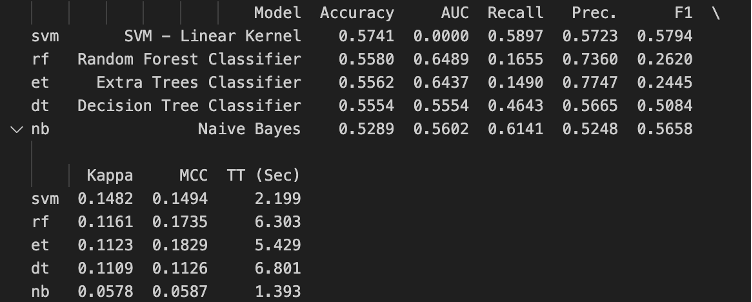

In [28]:
Image(filename="report_figure/figure4.png",width=600,height=600)

##### Zinc-Finger proteins set SVM

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix,accuracy_score

df = pd.read_csv("/home/users/ntu/leiz0003/10.27data/success_download.csv")
data = df[df['Class'] == 'C2H2 zinc finger factors']

df_dp = pd.read_csv("/home/users/ntu/leiz0003/10.27data/10.9_DNA_protein.csv")

train_df, test_df = train_test_split(data, test_size=9, random_state=10)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

training = df_dp[df_dp['Matrix_ID'].isin(train_df['ID'].tolist())]
testing = df_dp[df_dp['Matrix_ID'].isin(test_df['ID'].tolist())]
training = training.reset_index(drop=True)
testing = testing.reset_index(drop=True)

with open('/home/users/ntu/leiz0003/10.27data/protein_embedding_sequence.json', 'r') as file:
    protein_embedding_sequence = json.load(file)
    
with open('/home/users/ntu/leiz0003/10.27data/one_hot_encoding_DNA.json', 'r') as file:
    one_hot_encoding_DNA = json.load(file)
    
with open('/home/users/ntu/leiz0003/10.27data/Word2Vec_encoding_DNA.json', 'r') as file:
    Word2Vec_encoding_DNA = json.load(file)
    
peseq = protein_embedding_sequence[training['Uniprot_ID'][0]]
ohe_dna = one_hot_encoding_DNA[training['DNA_Sequence'][0]]
word2vec_dna = Word2Vec_encoding_DNA[training['DNA_Sequence'][0]]

training123 = {
    '0': peseq + word2vec_dna + [int(char) for char in ohe_dna]
}

training1_feature = pd.DataFrame.from_dict(training123, orient='index')
for i in range(len(training)):b
    peseq = protein_embedding_sequence[training['Uniprot_ID'][i]]
    ohe_dna = one_hot_encoding_DNA[training['DNA_Sequence'][i]]
    word2vec_dna = Word2Vec_encoding_DNA[training['DNA_Sequence'][i]]
    name = str(i)
    training1_feature.loc[name] = peseq + word2vec_dna + [int(char) for char in ohe_dna]
    
training1_feature['Label'] = training['Label'].tolist()
training1_feature.to_csv('/home/users/ntu/leiz0003/10.27data/training.csv', index=False)
    
    
peseq2 = protein_embedding_sequence[testing['Uniprot_ID'][0]]
ohe_dna2 = one_hot_encoding_DNA[testing['DNA_Sequence'][0]]
word2vec_dna2 = Word2Vec_encoding_DNA[testing['DNA_Sequence'][0]]

testing123 = {
    '0': peseq2 + word2vec_dna2 + [int(char) for char in ohe_dna2]
}

testing1_feature = pd.DataFrame.from_dict(testing123, orient='index')
for i in range(len(testing)):
    peseq2 = protein_embedding_sequence[testing['Uniprot_ID'][i]]
    ohe_dna2 = one_hot_encoding_DNA[testing['DNA_Sequence'][i]]
    word2vec_dna2 = Word2Vec_encoding_DNA[testing['DNA_Sequence'][i]]
    name = str(i)
    testing1_feature.loc[name] = peseq2 + word2vec_dna2 + [int(char) for char in ohe_dna2]
    
testing1_feature['Label'] = testing['Label'].tolist()
testing1_feature.to_csv('/home/users/ntu/leiz0003/10.27data/testing.csv', index=False)

scaler = StandardScaler()
X_train = training1_feature.drop('Label',axis=1)
y_train = training1_feature['Label']
X_test = testing1_feature.drop('Label',axis=1)
y_test = testing1_feature['Label']

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")

##### The accuracy of this is 0.478